[[0.267004 0.004874 0.329415 1.      ]
 [0.275191 0.194905 0.496005 1.      ]
 [0.212395 0.359683 0.55171  1.      ]
 [0.153364 0.497    0.557724 1.      ]
 [0.122312 0.633153 0.530398 1.      ]
 [0.288921 0.758394 0.428426 1.      ]
 [0.626579 0.854645 0.223353 1.      ]
 [0.993248 0.906157 0.143936 1.      ]]


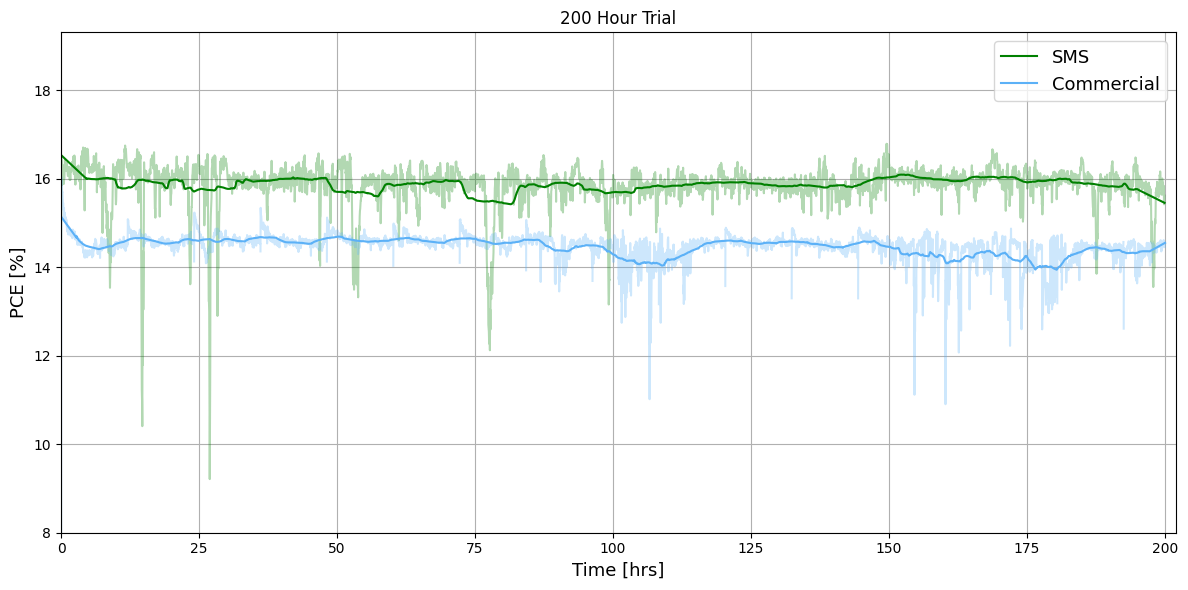

In [71]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from scipy.signal import savgol_filter

def ingest_litos_data(file_path):
    """
    Ingests data from a Litos Pixels text file and returns it as a NumPy array.
    """
    try:
        data_array = np.loadtxt(file_path, comments='#', delimiter='\t')
        return data_array
    except FileNotFoundError:
        print(f"Error: The file at '{file_path}' was not found.")
        return None
    except Exception as e:
        print(f"An error occurred while processing the file: {e}")
        return None

def plot_mppt_filtered(ax, csv_files, plot_title, data_type="pce",
                         filter_type=None, filter_params=None,
                         csv_pixels_to_plot=None, litos_pixels_to_plot=None,
                         litos_txt_file=None, max_hours=None):
    """
    Plot MPPT timeseries data from both CSV and Litos TXT files, with options for
    filtering, time cutoff, and selecting specific pixels for each data source.
    """
    overall_max_time = 0
    overall_max_value = 0

    # --- 1. CSV Data Processing ---
    if csv_files:
        csv_file = csv_files[0]
        arr = np.loadtxt(csv_file, delimiter=",", dtype=str)
        header_row = np.where(arr == "Time")[0][0]
        meta_data = {data[0]: data[1] for data in arr[:header_row, :2] if len(data) >= 2}
        headers = arr[header_row, :]
        arr = arr[header_row + 1 :, :]
        header_dict = {value: index for index, value in enumerate(headers)}
        pixel_V = arr[:, 1::2][:, 0:8].astype(float)
        pixel_mA = arr[:, 2::2][:, 0:8].astype(float)
        time = np.array(arr[:, header_dict["Time"]]).astype(float)

        if data_type == "pce":
            cell_area = float(meta_data.get("Cell Area (mm^2)", 128.0))
            data = ((pixel_V * pixel_mA / 1000) / (0.1 * cell_area)) * 100
            y_label = "PCE [%]"
        else:
            raise ValueError(f"Invalid data_type: {data_type}")

        if max_hours is not None and time.size > 0:
            mask = time <= (max_hours * 3600)
            time, data = time[mask], data[mask, :]

        # CSV Pixel Selection
        total_pixels_available = data.shape[1]
        csv_pixel_numbers = list(range(1, total_pixels_available + 1))
        if csv_pixels_to_plot is not None:
            valid_pixel_indices = [p - 1 for p in csv_pixels_to_plot if 0 < p <= total_pixels_available]
            if valid_pixel_indices:
                data = data[:, valid_pixel_indices]
                csv_pixel_numbers = [p for p in csv_pixels_to_plot if 0 < p <= total_pixels_available]
            else:
                data = np.array([[]])

        if data.shape[1] > 0:
            if len(time) > 5000:
                step = int(np.ceil(len(time) / 5000))
                time, data = time[::step], data[::step, :]
            time = time / 3600.0
            overall_max_time = max(overall_max_time, float(np.max(time)) if time.size > 0 else 0)
            overall_max_value = max(overall_max_value, float(np.max(data)) if data.size > 0 else 0)

            filtered_data = np.copy(data)
            if filter_type == "savgol":
                if not filter_params: filter_params = {'window_length': 101, 'polyorder': 3}
                if filter_params['window_length'] % 2 == 0: filter_params['window_length'] += 1
                for i in range(data.shape[1]):
                    if filter_params['window_length'] <= data.shape[0]:
                        filtered_data[:, i] = savgol_filter(data[:, i], **filter_params)

            NUM_PIXELS_TO_PLOT = data.shape[1]
            pixel_colors = plt.cm.viridis(np.linspace(0, 1, 8))
            print(pixel_colors)
            for i in range(NUM_PIXELS_TO_PLOT):
                lineName = f"SMS"
                color = 'green'
                ax.plot(time, data[:, i], color=color, alpha=0.3)
                plot_data = filtered_data if filter_type else data
                ax.plot(time, plot_data[:, i], label=lineName, color=color)

    # --- 2. Litos TXT Data Processing ---
    if litos_txt_file and data_type == "pce":
        litos_arr = ingest_litos_data(litos_txt_file)
        if litos_arr is not None and litos_arr.shape[0] > 1:
            litos_arr = litos_arr[1:]
            litos_time_data = litos_arr[:, 0::2]
            litos_pce_data = litos_arr[:, 1::2] * -1

            if max_hours is not None and litos_time_data.size > 0:
                mask = litos_time_data[:, 0] <= max_hours
                litos_time_data, litos_pce_data = litos_time_data[mask, :], litos_pce_data[mask, :]

            # Litos Pixel Selection
            total_litos_pixels = litos_pce_data.shape[1]
            litos_pixel_numbers = list(range(1, total_litos_pixels + 1))
            if litos_pixels_to_plot is not None:
                litos_valid_indices = [p - 1 for p in litos_pixels_to_plot if 0 < p <= total_litos_pixels]
                if litos_valid_indices:
                    litos_time_data = litos_time_data[:, litos_valid_indices]
                    litos_pce_data = litos_pce_data[:, litos_valid_indices]
                    litos_pixel_numbers = [p for p in litos_pixels_to_plot if 0 < p <= total_litos_pixels]
                else:
                    litos_pce_data = np.array([[]])

            if litos_pce_data.shape[1] > 0:
                overall_max_time = max(overall_max_time, float(np.nanmax(litos_time_data)))
                overall_max_value = max(overall_max_value, float(np.nanmax(litos_pce_data)))

                filtered_litos_data = np.copy(litos_pce_data)
                if filter_type == "savgol":
                    if not filter_params: filter_params = {'window_length': 201, 'polyorder': 1}
                    if filter_params['window_length'] % 2 == 0: filter_params['window_length'] += 1

                    for i in range(litos_pce_data.shape[1]):
                        y_col = litos_pce_data[:, i]

                        # Find non-NaN values for interpolation
                        not_nan_indices = ~np.isnan(y_col)

                        if np.any(not_nan_indices) and np.sum(not_nan_indices) > 1:
                            # Create an interpolated version of the data for filtering
                            # This uses linear interpolation to fill NaN gaps
                            interpolated_y = np.interp(
                                np.arange(len(y_col)),
                                np.where(not_nan_indices)[0],
                                y_col[not_nan_indices]
                            )

                            # Apply savgol_filter to the interpolated data
                            if filter_params['window_length'] <= len(interpolated_y):
                                filtered_litos_data[:, i] = savgol_filter(interpolated_y, **filter_params)
                            else:
                                # If data is too short for filter, just use raw interpolated data
                                filtered_litos_data[:, i] = interpolated_y
                        else:
                            # If no valid data or only one point, filtering not possible, use raw or NaNs
                            filtered_litos_data[:, i] = y_col

                NUM_LITOS_PIXELS = litos_pce_data.shape[1]
                pixel_colors = plt.cm.viridis(np.linspace(0, 1, min(10, 10)))
                for i in range(NUM_LITOS_PIXELS):
                    lineName = f"Commercial"
                    color = '#5CB1F7'

                    # Plot raw data (with original NaNs) faintly in the background
                    ax.plot(litos_time_data[:, i], litos_pce_data[:, i], color=color, alpha=0.3)

                    # Plot the filtered data, which is now continuous across NaNs
                    # No need for `if filter_type else litos_pce_data` as filtered_litos_data now always has a result
                    ax.plot(litos_time_data[:, i], filtered_litos_data[:, i], label=lineName, color=color)

    # --- 3. Final Plot Formatting ---
    ax.set_xlim(0, overall_max_time * 1.01)
    ax.set_ylim(8, overall_max_value * 1.15)
    ax.set_title(plot_title)
    ax.set_xlabel("Time [hrs]", fontsize=13)
    ax.set_ylabel("PCE [%]" if data_type == "pce" else y_label, fontsize=13)
    ax.grid(True)
    ax.legend(loc="best", fontsize=13)


def create_mppt_plot_filtered(csv_files, plot_title="MPPT Plot", data_type="pce",
                              filter_type=None, filter_params=None,
                              csv_pixels_to_plot=None, litos_pixels_to_plot=None,
                              figsize=(10,6), litos_txt_file=None, max_hours=None):
    """Convenience wrapper for the plotting function."""
    fig, ax = plt.subplots(tight_layout=True, figsize=figsize)
    plot_mppt_filtered(ax, csv_files, plot_title, data_type, filter_type,
                       filter_params, csv_pixels_to_plot, litos_pixels_to_plot,
                       litos_txt_file, max_hours)
    return fig, ax

# --- Example Usage ---
if __name__ == "__main__":
    fig_savgol, ax_savgol = create_mppt_plot_filtered(
        csv_files=[rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\July-30-2025 long stability\Combined__ID1__mppt.csv"],
        litos_txt_file=rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\CH1 - CY03 - REF\litos-pixels-power.txt",
        plot_title="200 Hour Trial",
        data_type="pce",
        filter_type="savgol",
        filter_params={'window_length': 201, 'polyorder': 1},
        csv_pixels_to_plot=[1],
        litos_pixels_to_plot=[1],
        max_hours=200,
        figsize=(12, 6)
    )
    plt.show()

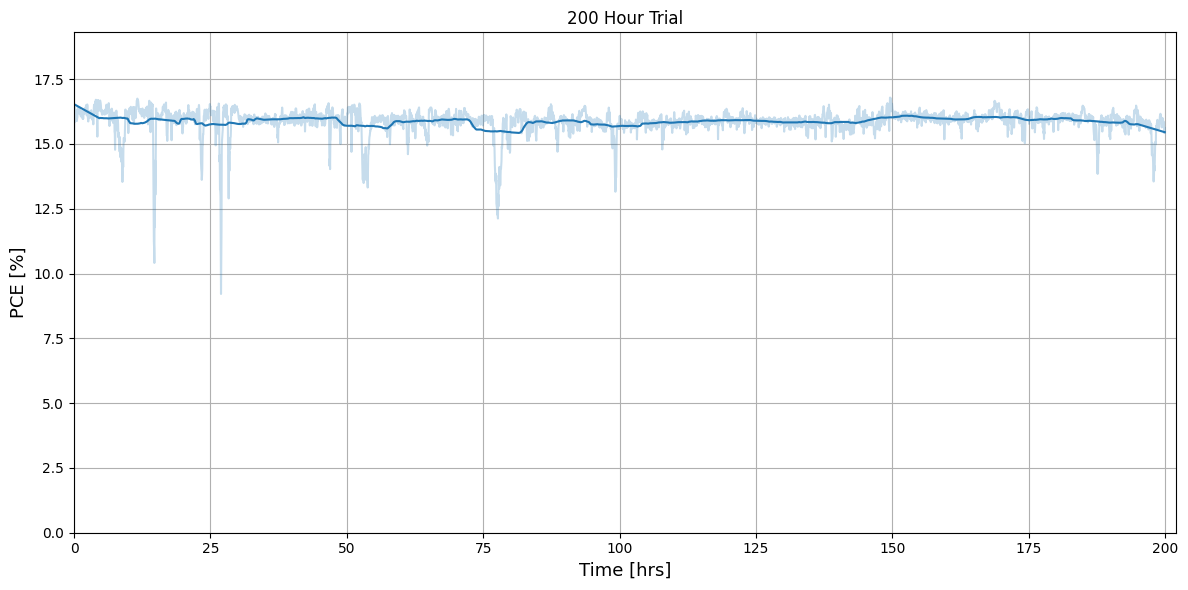

IndexError: index 0 is out of bounds for axis 0 with size 0

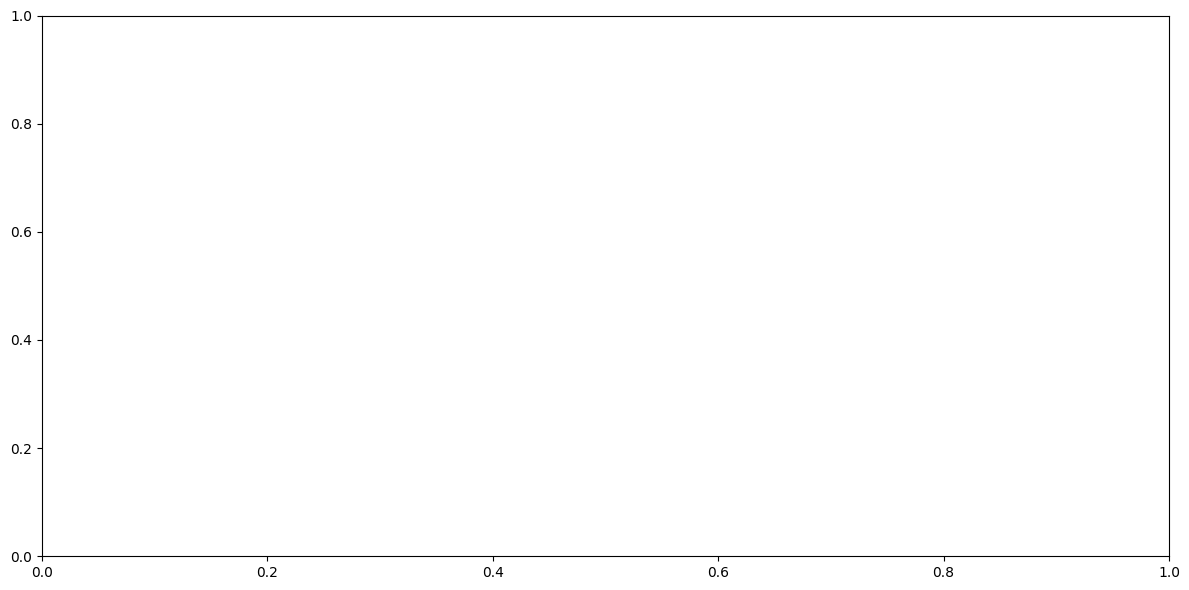

In [24]:

# Option 1: Using the recommended Savitzky-Golay filter
# A larger window_length (e.g., 101, 201) will make the plot smoother. It must be an odd integer.
# The polyorder should be less than the window_length (2 or 3 is usually good).
fig_savgol, ax_savgol = create_mppt_plot_filtered(
    csv_files=[rf"C:\Users\achen\Dropbox\code\Stability-Setup\data\July-30-2025 long stability\Combined__ID1__mppt.csv"],
    plot_title="200 Hour Trial",
    data_type="pce",
    filter_type="savgol",
    filter_params={'window_length': 200, 'polyorder': 1},
    pixels_to_plot=[1],
    figsize=(12,6)
)
plt.show()

fig_savgol, ax_savgol = create_mppt_plot_filtered(
    csv_files=[r'C:\Users\achen\Dropbox\code\Stability-Setup\data\CH1 - CY03 - REF\litos-pixels-power.txt'],
    plot_title="200 Hour Trial",
    data_type="pce",
    filter_type="savgol",
    filter_params={'window_length': 200, 'polyorder': 1},
    pixels_to_plot=[1],
    figsize=(12,6)
)
plt.show()

In [ ]:
def ingest_litos_data(file_path):
    """
    Ingests data from a Litos Pixels text file and returns it as a NumPy array.

    The function skips the header section and reads the tab-separated numerical data.
    Lines starting with '#' are treated as comments and ignored. 'NaN' values are
    handled correctly.

    Args:
        file_path (str): The path to the input data file.

    Returns:
        numpy.ndarray: A NumPy array containing the data from the file.
        Returns None if the file cannot be read or an error occurs.
    """
    try:
        # np.loadtxt is a powerful function for this task.
        # It can automatically skip lines starting with a comment character.
        # We specify '#' as the comment character and '\t' as the delimiter.
        data_array = np.loadtxt(file_path, comments='#', delimiter='\t')
        return data_array
    except FileNotFoundError:
        print(f"Error: The file at '{file_path}' was not found.")
        return None
    except Exception as e:
        print(f"An error occurred while processing the file: {e}")
        return None

# --- Example Usage ---
if __name__ == "__main__":
    litos_power = ingest_litos_data(r'C:\Users\achen\Dropbox\code\Stability-Setup\data\CH1 - CY03 - REF\litos-pixels-power.txt')

    print(litos_power)


[[ 0.0000000e+00            nan  0.0000000e+00 ...            nan
   0.0000000e+00            nan]
 [ 3.4390900e-02 -7.4746466e+00  3.4429610e-02 ... -8.1460791e+00
   3.4291103e-02 -9.7406569e+00]
 [ 4.0138967e-02 -1.5562317e+01  4.0171657e-02 ... -1.6215513e+01
   4.0071532e-02 -1.6574038e+01]
 ...
 [ 5.0512213e+02 -1.4273216e+01  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 5.0515051e+02 -1.4269574e+01  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 5.0518063e+02 -1.4244857e+01  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]]
